In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
train_out_dir = '../../02_train/out/'

# data, primarily for the ice flags
train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'

remove_PB = True
use_lat = True

if use_lat:
    train_data_fpath = train_data_fpath.replace("out", "out_WithLat")
    valid_data_fpath = valid_data_fpath.replace("out", "out_WithLat")
    train_out_dir = train_out_dir.replace("out", "out_WithLat")
    
    if remove_PB:
        
        train_predictions_fpath = train_out_dir + 'massive_lstm_train_preds_3_NoProcessBasedInput_.npy'
        valid_predictions_fpath = train_out_dir + 'massive_lstm_valid_preds_3_NoProcessBasedInput_.npy'

        eval_metrics_fpath = '../out_WithLat/massive_lstm_eval_metrics_3_NoProcessBasedInput_.npz'

    else:
        train_predictions_fpath = train_out_dir + 'avg_lstm_train_preds_0_.npy'
        valid_predictions_fpath = train_out_dir + 'avg_lstm_valid_preds_0_.npy'

        eval_metrics_fpath = '../out_WithLat/avg_lstm_eval_metrics_0_.npz'
    
else:
    if remove_PB:
        train_predictions_fpath = train_out_dir + 'massive_lstm_train_preds_0_NoProcessBasedInput_.npy'
        valid_predictions_fpath = train_out_dir + 'massive_lstm_valid_preds_0_NoProcessBasedInput_.npy'

        eval_metrics_fpath = '../out/massive_lstm_eval_metrics_0_NoProcessBasedInput_.npz'

    else:
        train_predictions_fpath = train_out_dir + 'massive_lstm_train_preds_1_.npy'
        valid_predictions_fpath = train_out_dir + 'massive_lstm_valid_preds_1_.npy'

        eval_metrics_fpath = '../out/massive_lstm_eval_metrics_1_.npz'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

# Import data

In [3]:
# Import both development partitions
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)

# Extract everything from training partition
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

# Extract everything from validation partition
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

In [4]:
train_predictions = np.load(train_predictions_fpath)
valid_predictions = np.load(valid_predictions_fpath)

In [5]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(train_variables == 'ice'))
depth_var_idx = int(np.argwhere(train_variables == 'MaxDepth'))
area_var_idx = int(np.argwhere(train_variables == 'LakeArea'))
assert valid_variables[ice_var_idx] == 'ice'
assert valid_variables[depth_var_idx] == 'MaxDepth'
assert valid_variables[area_var_idx] == 'LakeArea'

In [6]:
eval_metrics = np.load(eval_metrics_fpath, allow_pickle = True)

# Plot some simple time series

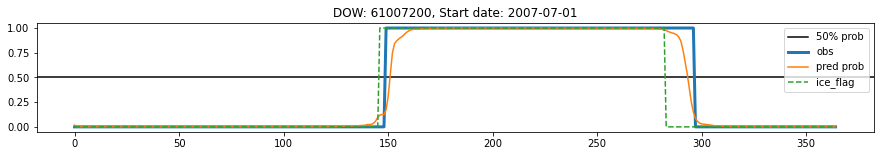

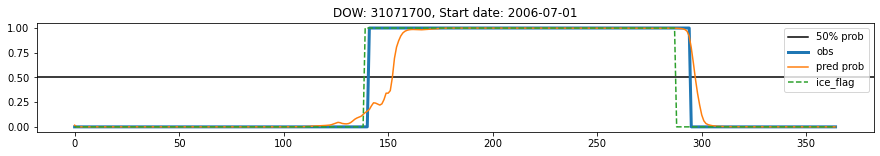

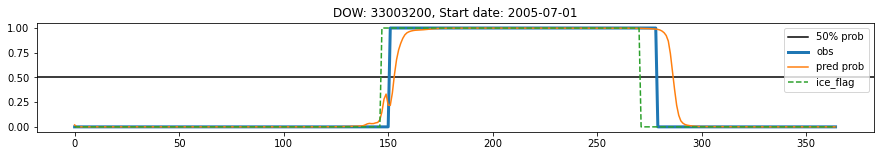

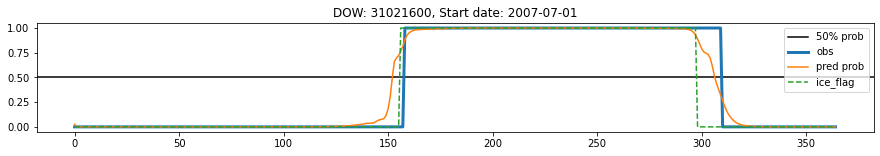

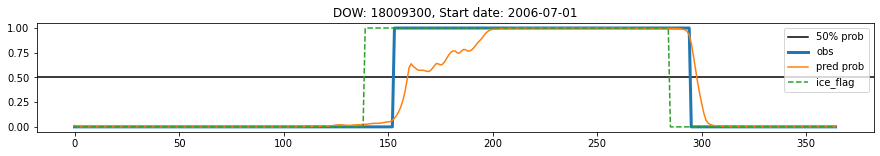

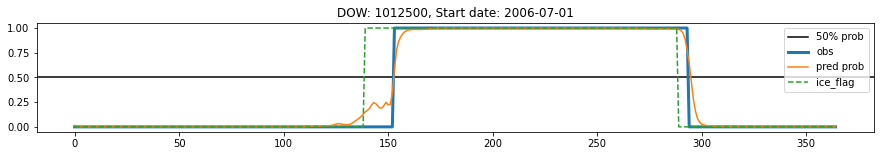

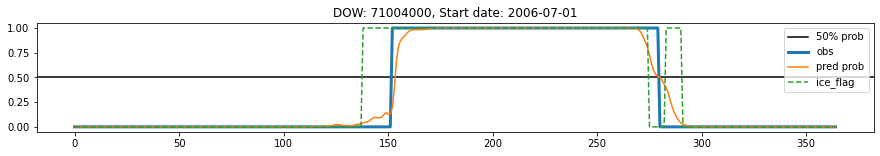

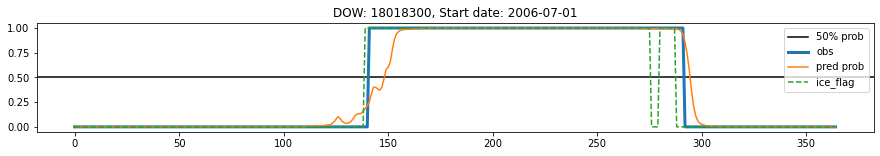

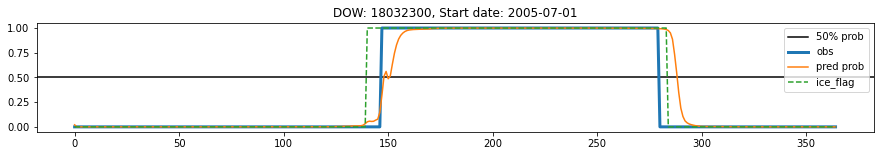

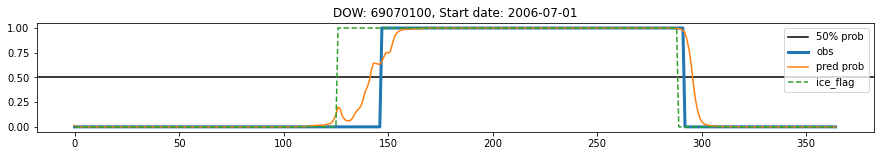

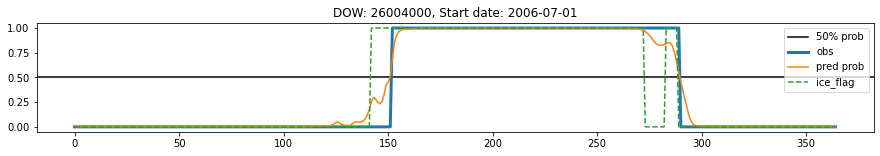

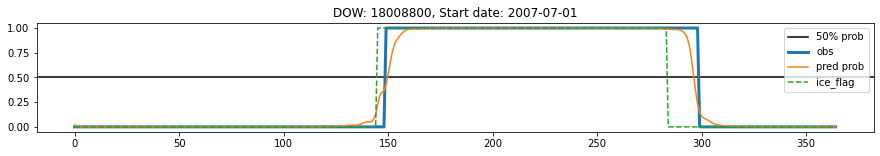

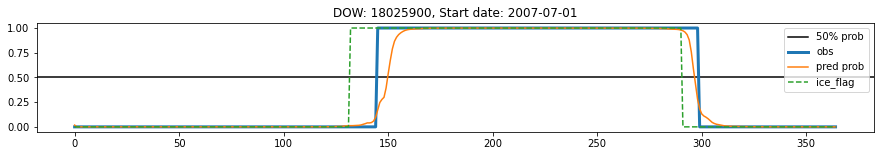

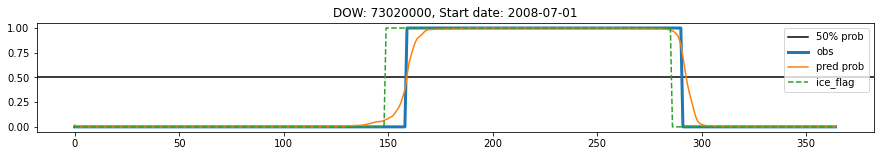

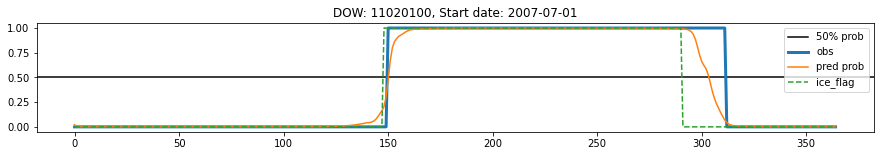

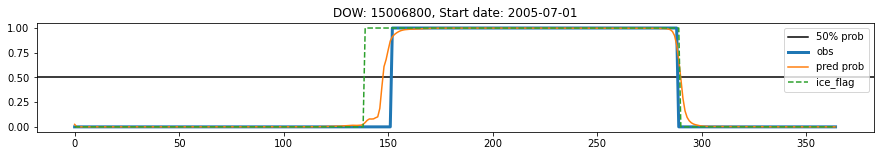

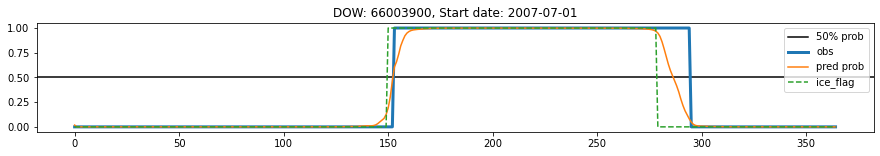

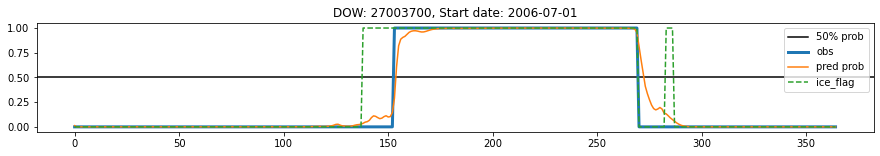

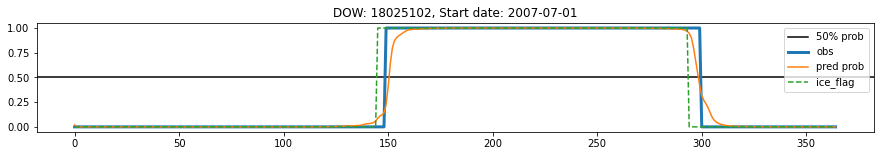

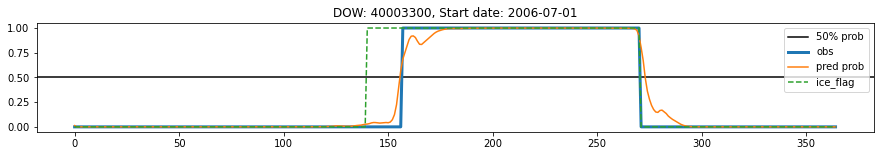

In [7]:
# Seed to view the same ones each time
np.random.seed(123)

# 10 random time series plots
# Includes:
#   Observation
#   Prediction
#   PB ice flag
#   50% probability line
#   Date and DOW of time series
for i in range(20):
    rand_i = np.random.choice(valid_predictions.shape[0])

    plt.figure(figsize = (15, 2))
    plt.axhline(0.5, label = '50% prob', color = 'black')
    plt.plot(valid_y[rand_i, :], label = 'obs', linewidth = 3)
    plt.plot(valid_predictions[rand_i, :, 0], label = 'pred prob')
    plt.plot(valid_x[rand_i, :, ice_var_idx], label = 'ice_flag', linestyle = '--')
    plt.title('DOW: ' + str(valid_DOW[rand_i]) + ', Start date: ' + valid_dates[rand_i][0])
    plt.legend();

# Spatial distribution

In [8]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':valid_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

In [9]:
# Assign all the errors to that newly merged dataframe
# (both are sorted by validation set DOW)
mapping_df['flag_error_ice_on'] = eval_metrics['flag_error_ice_on']
mapping_df['flag_error_ice_off'] = eval_metrics['flag_error_ice_off']
mapping_df['flag_error_dur']  = eval_metrics['flag_error_dur'] 
mapping_df['pred_error_ice_on']  = eval_metrics['pred_error_ice_on'] 
mapping_df['pred_error_ice_off'] = eval_metrics['pred_error_ice_off'] 
mapping_df['pred_error_dur'] = eval_metrics['pred_error_dur']

In [10]:
def map_error(error_col_suffix, jitter):
    # Craft the two column names
    process_based_col = 'flag_' + error_col_suffix
    new_model_col = 'pred_' + error_col_suffix
    
    # Set the colors to map to the same values
    cmap_extreme = np.max(np.abs([mapping_df[new_model_col].min(),
                                  mapping_df[new_model_col].max()]))
    
    # Configure a 2-plot arangement
    fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 0.5]})
    
    # Create the spatial jitter values (same for both subplots)
    lat_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    lon_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    
    # Plot ice flag errors with spatial jitter
    # Size and color are mapped to error
    ax[0].set_title("Process-based Ice Flags")
    ax[0].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[process_based_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[process_based_col])
    
    # Plot new prediction errors with spatial jitter
    # Size and color are mapped to error
    ax[1].set_title("New Model Predictions")
    im = ax[1].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[new_model_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[new_model_col])
    
    # Color legend
    fig.colorbar(im, label = 'Days', cax = ax[2]);

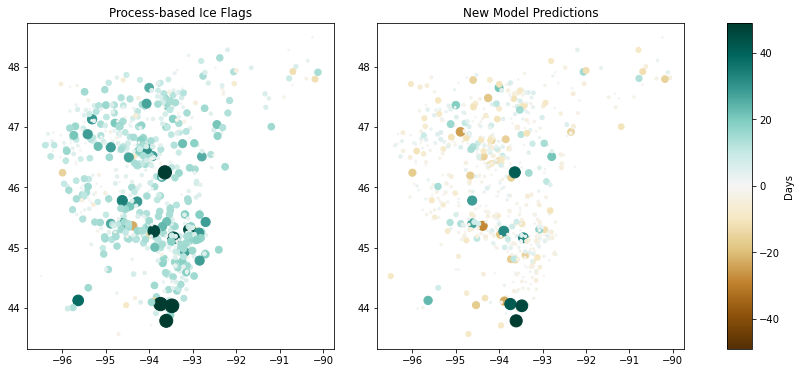

In [11]:
map_error('error_ice_on', 0.2)

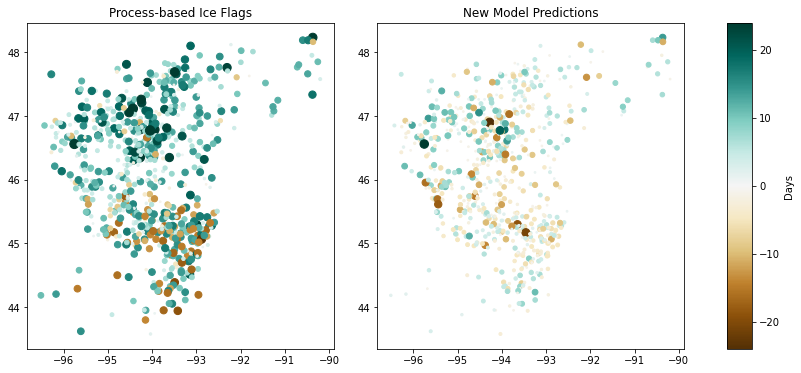

In [12]:
map_error('error_ice_off', 0.2)

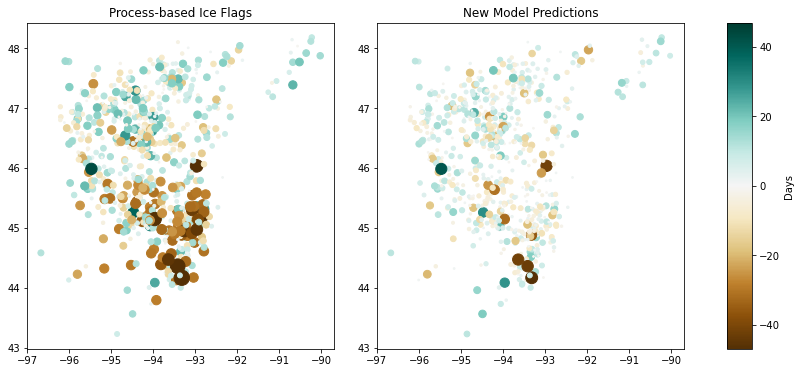

In [13]:
map_error('error_dur', 0.2)

# Do residuals significantly vary with certain lake characteristics?

Some additional evaluation for how residuals change with certain lake characteristics: lat, long, depth, and area. These residual-inspecting plots include a nonlinear correlation and p-value

In [14]:
def plot_and_print_resid_corr(values, label):
    
    # globally accessed mapping_df, assuming its column names (residuals), and associated axis labels
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    
    fig.suptitle('Correlation of Residuals with Static Lake Descriptions')

    ax[0].scatter(values, mapping_df['flag_error_ice_on'], alpha = 0.5, label = 'Process-based')
    ax[1].scatter(values, mapping_df['flag_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['flag_error_dur'], alpha = 0.5)
    ax[0].scatter(values, mapping_df['pred_error_ice_on'], alpha = 0.5, label = 'LSTM')
    ax[1].scatter(values, mapping_df['pred_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['pred_error_dur'], alpha = 0.5)
    ax[0].legend()

    ax[0].set_ylabel('Residual')
    ax[0].set_title('Ice on')
    ax[1].set_title('Ice off')
    ax[1].set_xlabel(label, fontsize = 12)
    ax[2].set_title('Ice duration')
    
    plt.show()

    print('\nProcess-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['flag_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['flag_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['flag_error_dur']))
    print('\nLSTM-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['pred_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['pred_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['pred_error_dur']), '\n')

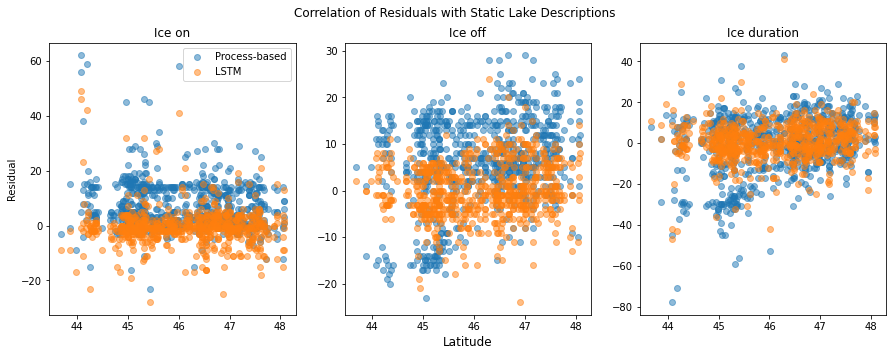


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.16663240835880871, pvalue=6.758034034650171e-06)
Ice off:	 SpearmanrResult(correlation=0.19727341533802786, pvalue=9.083385131342693e-08)
Ice duration:	 SpearmanrResult(correlation=0.1973816575272098, pvalue=8.934591009267668e-08)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.042028197697287384, pvalue=0.25938676264120625)
Ice off:	 SpearmanrResult(correlation=0.13591544774050163, pvalue=0.00024953418193428457)
Ice duration:	 SpearmanrResult(correlation=0.11694534221100905, pvalue=0.0016456608846894887) 



In [15]:
plot_and_print_resid_corr(mapping_df['lat'], 'Latitude')

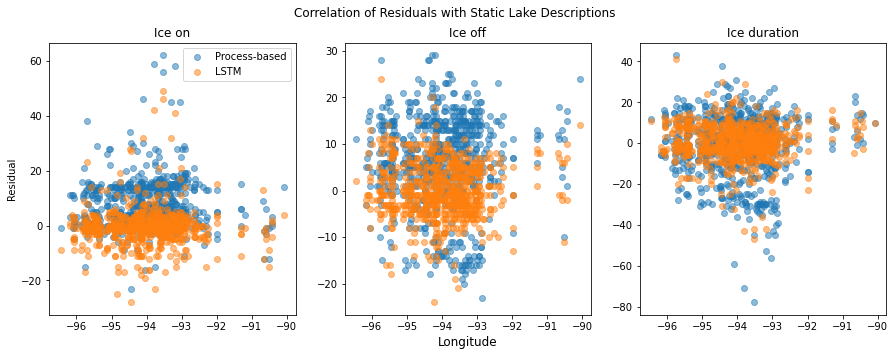


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.11973368538663258, pvalue=0.0012673207722965808)
Ice off:	 SpearmanrResult(correlation=0.03177991679788208, pvalue=0.39384566618460803)
Ice duration:	 SpearmanrResult(correlation=-0.017306612631775697, pvalue=0.6424624086987114)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.0031134287340297707, pvalue=0.933443434825014)
Ice off:	 SpearmanrResult(correlation=-0.03681540804092153, pvalue=0.3232246409801428)
Ice duration:	 SpearmanrResult(correlation=-0.029484836309622068, pvalue=0.428909849072172) 



In [16]:
plot_and_print_resid_corr(mapping_df['long'], 'Longitude')

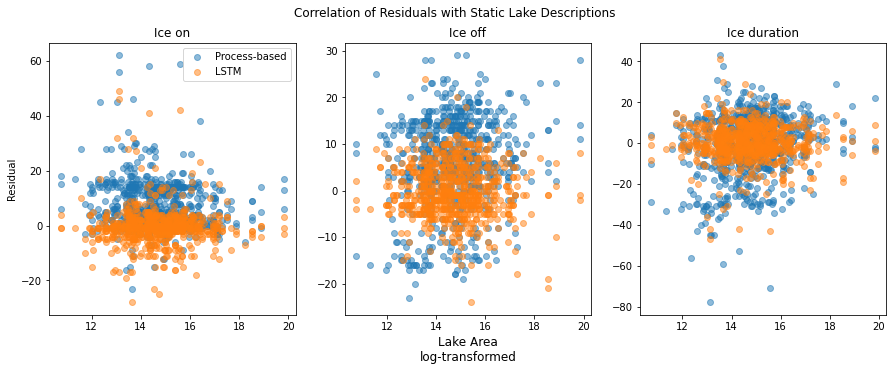


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.1765464411612242, pvalue=1.8138030516721042e-06)
Ice off:	 SpearmanrResult(correlation=0.11556739634171727, pvalue=0.0018686617367996222)
Ice duration:	 SpearmanrResult(correlation=0.16315764911833489, pvalue=1.0528911324138296e-05)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.01449096037000838, pvalue=0.6974842539170367)
Ice off:	 SpearmanrResult(correlation=-0.02661566415154541, pvalue=0.47519516384912996)
Ice duration:	 SpearmanrResult(correlation=-0.020882505001670614, pvalue=0.5753410019112322) 



In [17]:
areas = valid_x[:, 0, area_var_idx]

plot_and_print_resid_corr(areas, 'Lake Area\nlog-transformed')

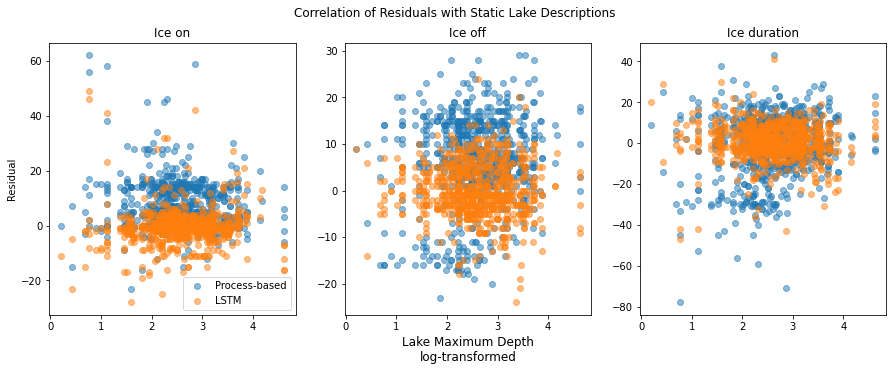


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.17403406839435473, pvalue=2.5493007399171365e-06)
Ice off:	 SpearmanrResult(correlation=0.04333761081355708, pvalue=0.24482428423145888)
Ice duration:	 SpearmanrResult(correlation=0.11020986206666958, pvalue=0.0030243549503384897)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.09074808615357287, pvalue=0.014719171726897297)
Ice off:	 SpearmanrResult(correlation=-0.05137373623464501, pvalue=0.16791507847556225)
Ice duration:	 SpearmanrResult(correlation=-0.08222147729368343, pvalue=0.027160077967476475) 



In [18]:
depths = valid_x[:, 0, depth_var_idx]

plot_and_print_resid_corr(depths, 'Lake Maximum Depth\nlog-transformed')

# List of significant residual correlations


## With latitude

### ...and with process-based inputs

##### Latitude

* The avg lstm's residuals are positively and signficantly correlated with latitude for ice off and ice duration
    
##### Lake depth
    
* The avg lstm's residuals are significantly and positively correlated for ice off

#### In total

* The avg lstm's residuals are significantly correlated with static lake descriptions in 3/12 tested scenarios, with those primarily being latitude

### ... and with NO process-based inputs

##### Latitude

* The massive lstm's residuals are positively and signficantly correlated with latitude for ice off and ice duration
    
##### Lake depth
    
* The massive lstm's residuals are significantly and positively correlated for ice on while being significantly and negatively correlated for ice duration

#### In total

* The massive lstm's residuals are significantly correlated with static lake descriptions in 4/12 tested scenarios, with those being equally split between latitude and lake depth.

While latitude still holds significant correlations, the magnitude of those correlations can be up to 3x smaller


## Without latitude

### ...and with process-based inputs

##### Latitude

* The process-based model's and the massive lstm's residuals are signficantly correlated with latitude on all 3 date-based predictions
    * Negatively correlated for ice on, positively correlated for ice off and ice duration
  
##### Longitude
  
* The process-based model's residuals are significantly and positively correlated with longitude for ice on prediction

##### Lake area

* The process-based model's residuals are significantly correlated with lake area on all 3 date-based predictions
    * Negatively correlated for ice on, positively correlated for ice off and ice duration
    
##### Lake depth
    
* The process-based model's residuals are significantly correlated with lake depth on ice on and ice duration prediction
    * Negatively correlated for ice on, positively correlated for ice duration
* The massive lstm's residuals are significantly and positively correlated for ice on prediction

#### In total

* The process-based model's residuals are significantly correlated with static lake descriptions in 9/12 tested scenarios, most notably latitude and lake area for all 3 date-based predictions.
* The massive lstm's residuals are significantly correlated with static lake descriptions in 4/12 tested scenarios, with 3 of those scenarios involving latitude.

### ... and with NO process-based inputs

##### Latitude

* massive lstm residuals were significantly and positively correlated with latitude for ice off and ice duration

#### In total

* The massive lstm's residuals are significantly correlated with static lake descriptions in 2/12 tested scenarios, with both of those scenarios involving latitude.
